# Modelling a stellar stream from a dwarf galaxy

This tutorial will go through the necessary aspects of the `galpy.df.streamspraydf` class so that, similar to the orbit tutorial, you will have sufficient knowledge to get started on modelling streams. In this one, we also need to use `galpy.orbit`, so if you haven't seen it or need a refresher, look at segments 1 to 4 in the orbit tutorial (which covers orbit initialization, timescale, and potential). That being said, there will be comments in this tutorial that explain what each line of code is doing.

## Outline

1. Setting up the model function
2. Sampling the distribution function
3. Displaying the stream
4. Example: simulating a tidal stream for Bootes III

Context:

Stream simulation is done using a galpy class called particle-spray stream distribution function, [streamspraydf](https://docs.galpy.org/en/v1.8.3/reference/streamspraydf.html#galpy.df.streamspraydf). As the documentation says, this simulation method is adapted from the particle-spray method in [Fardal et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015MNRAS.452..301F/abstract), with the galpy implementation explained in [Qian et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.511.2339Q/abstract). The documentation has a [sample usage](https://docs.galpy.org/en/v1.8.3/streamdf.html#streamspray-tutorial) that you can refer to, but this tutorial also has more examples later.

Briefly, among the many ways to model physical systems, there is one method called N-body simulation, and another method called test-particle method. The N-body simulation treats every particle in a system (of stars or galaxies) to have gravitational influence on other particles, so each particle's movement is affected by all other particles in the system. This creates more accurate models when every object has significant gravitational influence, but it requires a lot of computation power. On the other hand, the test-particle method treats the object (a star or even a whole galaxy) we are modelling as a "point" particle, similar to a point charge in an electric field. The test-particle moves in the gravitational potential provided, and it is considered to have minimal effect back on the potential.

The method in `streamspraydf` is the test-particle method, which works because we are mostly using it to model a satellite galaxy that's much smaller compared to the Milky Way. In short, we assume the progenitor galaxy's orbit is similar to the orbit of the dwarf galaxy that we have now, and we pick a time when disruption began. The model will integrate the orbit backwards and, from the time of disruption to the present time, the model will sample for stars at different points in time. This basically says that as the galaxy moves along its orbit, stars are continuously getting stripped off its main system, what we collect are the particles leaving the system, and that is the stellar stream we want.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units

from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.df import streamspraydf

A new version of galpy (1.8.3) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


## 1. Setting up the model function

We define the `streamspraydf` instance like the line below (with focus on six parameters):
```python
spdf = streamspraydf(progenitor_mass, progenitor, pot, tdisrupt, rtpot, leading)
```

Let's break down what these parameters are, and build up the code in the example that you'll see later.

**`progenitor_mass`**: a value for the progenitor galaxy's mass, and the input for this can be a Quantity (that is, a value with an astropy unit). For the example below, we assume a progenitor mass of $10^7$ M$_\odot$. The units will be assigned when we use this value in the instantiation of the model.
```python
mass = 1e7
```

**`progenitor`**: an `Orbit` instance for the dwarf galaxy that will be used to simulate a stream. In this example we will use the dwarf galaxy Bootes III, so let's make an orbit for it. Assuming its 6D phase space parameters are defined in the list `boo3_6D`, we will define the orbit instance as follows (refer to the orbit tutorial if you are confused):
```python
orbit_boo3 = Orbit(boo3_6D, radec=True)
```

**`pot`**: the Galactic potential involved in this simulation. We stick with the tradition and use `MWPotential2014`, which also keeps the orbit initialization above a consistent one, because the default `ro` and `vo` values are already matched with `MWPotential2014`. In an alternative case, we can add extra components to the Galactic potential, particularly the potential of the LMC, as mentioned in the orbit tutorial. We will see how this is done in the full example later.

**`tdisrupt`**: a value for the time since disruption started. This can also be entered with astropy units. It is important to be consistent with using Quantities. If we specified mass with units, here we must assign units to the time too. Otherwise, galpy's natural units are used here but won't be used for the mass, and we will get a wrong result. In our example, we will assign units when passing the value into the parameter of the function. **Note**: choose a tdisrupt value around the same time your orbit makes a complete cycle, then tweak it from there, otherwise you may find your stream result to be loosely scattered across a large region. Here's the disruption time we choose, in Gyr:
```python
tdisrupt = 3
```

**`rtpot`**: This is the potential used to calculate the tidal radius and circular velocity. It is the same as `pot` when you don't have extra components in `pot`. [Its documentation](https://docs.galpy.org/en/v1.8.3/reference/streamspraydf.html#galpy.df.streamspraydf) says the following: "sometimes you need to drop parts of the potential that don’t allow the tidal radius / circular velocity to be computed, such as velocity-dependent forces". If we include the LMC in `pot` (recall orbit tutorial), then the LMC as a Hernquist potential and the non-inertial-frame-force are both things that interfere with the calculation. In that case, we still keep these parts in `pot`, but for `rtpot` we will only input the `MWPotential2014` part.

**`leading`**: This is a boolean input indicating if we want the model to generate only the leading arm or trailing arm for the simulated stream. Depending on the position and the velocity of the generated particles, the model will determine if a particle belongs to the leading arm or trailing arm of the stream. The default value for this parameter is True, so typically we want to create a second `streamspraydf` instance with everything the same but set `leading = False`.

This covers the necessary parameters we use. For the other parameters, see the [API] of the class, where you can also visit the source code to see how each parameter is used. **Note**: just like defining orbits, if we are using a potential other than `MWPotential2014`, we must specify the `ro` and `vo` parameters (when we leave them blank, they will take the values in the configuration file, and that would be corresponding to `MWPotential2014`). Once again, the quick way to obtain the correct `ro` and `vo` is through ` galpy.util.conversion.get_physical()` where the input is the potential model you are using (see section 1.4 in the orbit tutorial). 

So, here is the full instantiation of the `streamspraydf` instance:
```python
# Leading arm
spdf = streamspraydf(progenitor_mass = mass * units.M_sun,
                     progenitor = orbit_boo3,
                     pot = total_potential,
                     tdisrupt = tdisrupt * units.Gyr,
                     rtpot = MWPotential2014)

# Trailing arm
spdft = streamspraydf(progenitor_mass = mass * units.M_sun,
                      progenitor = orbit_boo3,
                      pot = total_potential,
                      tdisrupt = tdisrupt * units.Gyr,
                      rtpot = MWPotential2014,
                      leading = False)
```
Note that `mass` and `tdisrupt` have been assigned their astropy units. We are writing it this way to emphasize that we have used Quantities as input. `total_potential` includes LMC potential and the MW barycentric acceleration, `total_potential = MWPotential2014 + moving_lmcpot + nip`, the example will show how this is defined. By doing this, we will need to drop the `moving_lmcpot + nip` terms when calculating tidal radius and circular velocity, hence we have `rtpot = MWPotential2014`.

## 2. Sampling the distribution function

To obtain the simulated stream result is rather simple on the client side, we just need to use the `streamspraydf.sample()` method (see [API here](https://docs.galpy.org/en/v1.8.3/reference/streamspraydfsample.html)). To reiterate, we are sampling the distribution function because the method basically says that as the progenitor galaxy moves along its orbit (an orbit similar to the dwarf galaxy we know), its stars are getting stripped off by tidal force and are leaving the system. What we sample are the stars leaving the system as the galaxy goes from the time of disruption to the present.

The API makes it clear what kind of parameters are there for this method. We will mainly use two of them:
```python
spdf.sample(n=200, integrate=True)
```
The `n` is the number of particles/stars we want to get, usually 200 is enough, and the more stars you want to sample the longer it takes to run. `integrate = True` will give us orbit instance as output, integrated to the present time (the [sample usage](https://docs.galpy.org/en/v1.8.3/streamdf.html#streamspray-tutorial) also says that setting this parameter to False is good for visualizing when stars get stripped from the progenitor). Additionally you can set `return_orbit = False` to get output in Galactocentric Cylindrical coordinates `[R, vR, vT, z, vz, phi]`, or set `returndt = True` to get an extra returned output that tells you the time since the star was stripped. But I think those should only be used when needed, as a typical stream output can be generated with just `n` and `integrate=True`.

So, since we have a function for the leading arm and another for the trailing arm, we sample both of them. Also as the output are orbit instances, we name it starting with orbit to remind ourselves
```python
orbit_leading = spdf.sample(n=200, integrate=True)
orbit_trailing = spdft.sample(n=200, integrate=True)
```

## 3. Displaying the stream

With the model function defined and then sampled on, we have already obtained the stream simulation result. All we need is to display it. Because we used `integrate = True`, the output is just like any other `Orbit` object we've been using in orbit integration. So it has all the [attributes](https://docs.galpy.org/en/v1.8.3/reference/orbit.html#attributes) that orbits have. We can plot the stars' celestial coordinates, proper motions, distance moduli, etc. 

The plotting is all up to the user to decide, but just as a recommendation, if we don't need to distinguish the leading and trailing arms, it might be easier to plot by joining the properties from the two parts. That is, we can say `np.append(orbit_leading.ra(), orbit_trailing.ra())`.

It may also be a good practice to save the simulated result, so that you can load back in the same result and also save time on recomputing the result. An easy way is to use `pickle`, it saves the `Orbit` instances as they are, so when you load them back in, they are still orbits.
```python
import pickle

# Writing
fileObj = open('orbit_leading.obj', 'wb')
pickle.dump(orbit_leading, fileObj)
fileObj.close()

# Loading
fileObj = open('orbit_leading.obj', 'rb')
orbit_leading = pickle.load(fileObj)
fileObj.close()
```

Now, we can see the full example.

## 4. Example: simulating a tidal stream for Bootes III

We'll put the imports here just to make the code complete.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units

from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.df import streamspraydf

In [3]:
# 6D phase space parameters
boo3_6D = [209.3, 26.8, 46.5, -1.16, -0.88, 189.11]

# Orbit of Bootes III
orbit_boo3 = Orbit(boo3_6D, radec=True)

In [4]:
def get_total_potential(forward=False):
    """Return the total potential for integration, which contains the model MWPotential2014,
    the LMC as a Hernquist potential, and the Milky Way barycentric acceleration, as a 
    non-inertial frame force.
    
    The <forward> parameter determines if we want the LMC potential to be forward or backward
    integrated. (In this example usage for stream modelling, forward is not needed)
    """
    mass_lmc = 1.38e11               # M_sun
    rscale = 16.09                   # kpc
    rhm = rscale * (1 + np.sqrt(2))  # kpc

    orbit_LMC = Orbit.from_name('LMC')

    cdf = ChandrasekharDynamicalFrictionForce(GMs=mass_lmc*units.Msun, rhm=rhm*units.kpc, dens=MWPotential2014)

    ts = np.linspace(0., 5., 1001)*units.Gyr
    
    if forward:
        orbit_LMC.integrate(ts, MWPotential2014 + cdf)
    else:
        orbit_LMC.integrate(-ts, MWPotential2014 + cdf)
        
    lmcpot = HernquistPotential(amp=2*mass_lmc*units.Msun, a=rscale*units.kpc)
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot)

    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    if forward:
        t_intunits= orbit_LMC.time(use_physical=False)
    else:
        t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return MWPotential2014 + nip + moving_lmcpot

In [5]:
total_potential = get_total_potential()

In [6]:
tdisrupt = 3  # Gyr
mass = 1e7    # M_sun (mass of progenitor)

In [7]:
# Leading arm
spdf = streamspraydf(progenitor_mass = mass * units.M_sun,
                     progenitor = orbit_boo3,
                     pot = total_potential,
                     tdisrupt = tdisrupt * units.Gyr,
                     rtpot = MWPotential2014)

# Trailing arm
spdft = streamspraydf(progenitor_mass = mass * units.M_sun,
                      progenitor = orbit_boo3,
                      pot = total_potential,
                      tdisrupt = tdisrupt * units.Gyr,
                      rtpot = MWPotential2014,
                      leading = False)

The warning message saying the forces are dissipative may be coming from the addition of the LMC Hernquist potential and the non-inertial-frame-force to the MWPotential2014 model. When we sample for the stream particles these warnings show up for every star, so we will turn off the warning below for the notebook to look clean, but you should leave the warnings on when you are doing your work.

In [8]:
import warnings
from galpy.util import galpyWarning
warnings.filterwarnings('ignore', category=galpyWarning)

In [9]:
orbit_leading = spdf.sample(n=200, integrate=True)
orbit_trailing = spdft.sample(n=200, integrate=True)

In [10]:
# Integrate the Boo III orbit for visualization
ts = np.linspace(0, 5, 1001)*units.Gyr
orbit_boo3.integrate(-ts, total_potential)

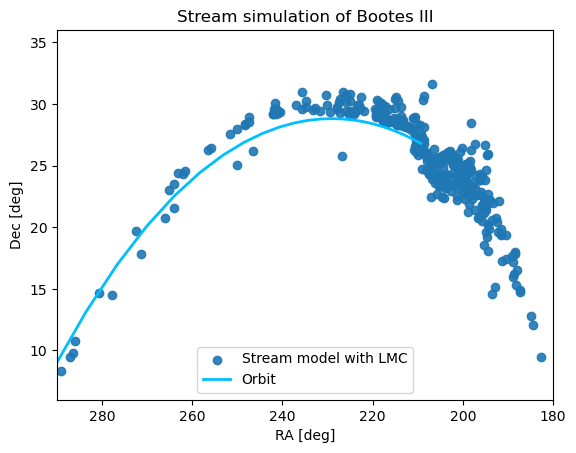

In [11]:
fig, ax = plt.subplots()

ax.scatter(np.append(orbit_leading.ra(), orbit_trailing.ra()), 
           np.append(orbit_leading.dec(), orbit_trailing.dec()), 
           c='tab:blue', label='Stream model with LMC', alpha=0.9)
ax.plot(orbit_boo3.ra(-ts)[:50], orbit_boo3.dec(-ts)[:50], c='deepskyblue', lw=2, label='Orbit')
ax.set_xlim(180, 290)
ax.set_ylim(6, 36)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.set_title('Stream simulation of Bootes III')
ax.invert_xaxis()
ax.legend(loc='lower center')
plt.show()

## Comparing the above with another model without LMC

A model without LMC is much easier to make because we don't need to specify `rtpot`, as we will just have `pot = MWPotential2014`, and on its own there are no components that need to be dropped in any calculation.

In [12]:
orbit_boo3_nolmc = Orbit(boo3_6D, radec=True)

In [13]:
# Leading arm
spdf_nolmc = streamspraydf(progenitor_mass = mass * units.M_sun,
                           progenitor = orbit_boo3_nolmc,
                           pot = MWPotential2014,
                           tdisrupt = tdisrupt * units.Gyr)

# Trailing arm
spdft_nolmc = streamspraydf(progenitor_mass = mass * units.M_sun,
                            progenitor = orbit_boo3_nolmc,
                            pot = MWPotential2014,
                            tdisrupt = tdisrupt * units.Gyr,
                            leading = False)

In [14]:
orbit_leading2 = spdf_nolmc.sample(n=200, integrate=True)
orbit_trailing2 = spdft_nolmc.sample(n=200, integrate=True)

In [15]:
orbit_boo3_nolmc.integrate(-ts, MWPotential2014)

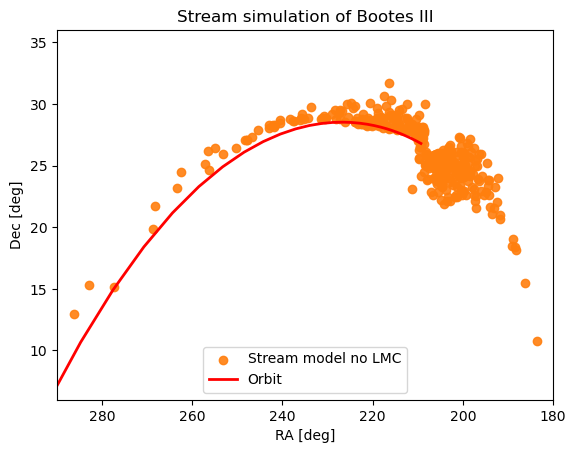

In [16]:
fig, ax = plt.subplots()

ax.scatter(np.append(orbit_leading2.ra(), orbit_trailing2.ra()), 
           np.append(orbit_leading2.dec(), orbit_trailing2.dec()), 
           c='tab:orange', label='Stream model no LMC', alpha=0.9)
ax.plot(orbit_boo3_nolmc.ra(-ts)[:50], orbit_boo3_nolmc.dec(-ts)[:50], c='red', lw=2, label='Orbit')
ax.set_xlim(180, 290)
ax.set_ylim(6, 36)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.set_title('Stream simulation of Bootes III')
ax.invert_xaxis()
ax.legend(loc='lower center')
plt.show()

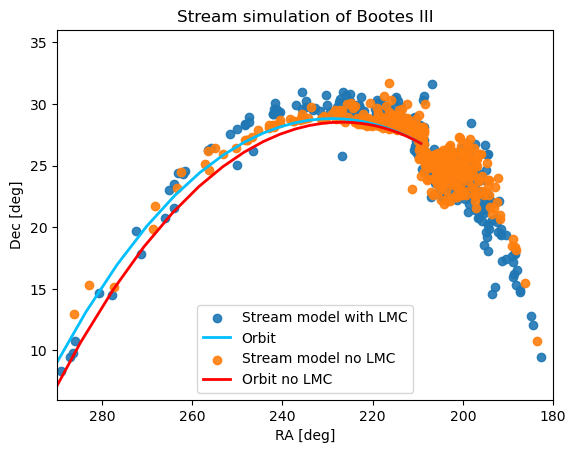

In [17]:
fig, ax = plt.subplots()

ax.scatter(np.append(orbit_leading.ra(), orbit_trailing.ra()), 
           np.append(orbit_leading.dec(), orbit_trailing.dec()), 
           c='tab:blue', label='Stream model with LMC', alpha=0.9)
ax.plot(orbit_boo3.ra(-ts)[:50], orbit_boo3.dec(-ts)[:50], c='deepskyblue', lw=2, label='Orbit')
ax.scatter(np.append(orbit_leading2.ra(), orbit_trailing2.ra()), 
           np.append(orbit_leading2.dec(), orbit_trailing2.dec()), 
           c='tab:orange', label='Stream model no LMC', alpha=0.9)
ax.plot(orbit_boo3_nolmc.ra(-ts)[:50], orbit_boo3_nolmc.dec(-ts)[:50], c='red', lw=2, label='Orbit no LMC')
ax.set_xlim(180, 290)
ax.set_ylim(6, 36)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.set_title('Stream simulation of Bootes III')
ax.invert_xaxis()
ax.legend(loc='lower center')
plt.show()

## Possible mistakes:

**Unit consistency**: It may be clearer in context to use physical units on some of the parameters, such as the time and the mass. However, we just need to make sure that if we used physical units for one thing, we must use units on all other things (that are physical quantities). In the `streamspraydf` parameters, the time and mass have physical units, whereas the potential and the orbit are models and instances of other classes, so that was all correct. But if you ever find the output looking strange, check if the time or mass are not consistent (they are either both in galpy's natural units or both have astropy units).

**Using different potentials**: The set up for a potential involving the LMC and the MW's acceleration can always get tricky, which the orbit integration tutorial also explained. We must keep all the timescale inputs to be backwards, or all of them forwards, otherwise there's inconsistency in that too. In generating the stream, we only need backward orbits, so just make sure the LMC's orbit is integrated with a backwards timescale, and the interpolation for the non-inertial-frame-force uses a backwards timescale too.